# Table of Contents

- [Знакомство с базой данных](#chapter0)  
- [Предобработка данных](#chapter1)
    - [Удаление пропусков](#chapter11)
    - [Обработка аномальных значений](#chapter12)
    - [Удаление пропусков (продолжение)](#chapter13)
    - [Изменение типов данных](#chapter14)
    - [Обработка дубликатов](#chapter15)
    - [Категоризация данных](#chapter16)
- [Исследование данных](#chapter2)
- [Общий вывод](#chapter2)

## Знакомство с базой данных <a name="chapter0"></a>

In [2]:
import pandas as pd
#загрузим библиотеки для визуализации, они нам понадобятся ближе к концу, когда будем строить графики
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "svg"

init_notebook_mode(connected=True)

In [ ]:
data=pd.read_csv('E:\\Data\\Git\\Портфолио\\CreditRating\\data.csv')

In [3]:
print(data.head(20))

    children  days_employed  dob_years            education  education_id  \
0          1   -8437.673028         42               высшее             0   
1          1   -4024.803754         36              среднее             1   
2          0   -5623.422610         33              Среднее             1   
3          3   -4124.747207         32              среднее             1   
4          0  340266.072047         53              среднее             1   
5          0    -926.185831         27               высшее             0   
6          0   -2879.202052         43               высшее             0   
7          0    -152.779569         50              СРЕДНЕЕ             1   
8          2   -6929.865299         35               ВЫСШЕЕ             0   
9          0   -2188.756445         41              среднее             1   
10         2   -4171.483647         36               высшее             0   
11         0    -792.701887         40              среднее             1   

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
None


##  Предобработка данных <a name="chapter1"></a>

###  Удаление пропусков <a name="chapter11"></a>

In [5]:
print(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


Данные в целом неплохие, пропуски по доходу и количенству дней работы объяснимы, но могут повлиять на наш результат.

Один из пропусков — days_employed. Пропуски в этом столбце мы обработаем на следующем этапе. Другой столбец с пропущенными значениями — total_income — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца income_type. Например, у человека с типом занятости сотрудник пропуск в столбце total_income должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [6]:
#Посчитаем сначала медианные значения дохода по каждой категории занятых.
med_income=data.groupby(['income_type'])['total_income'].median()
#Теперь заменим пропуски в столюце с доходами на полученные медианы

for d in data['income_type'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в income_type текущий тип дохода (d) и есть пропуски в total_income 
    data.loc[(data['income_type'] == d) & (data['total_income'].isna()), 'total_income'] = med_income[d]
    # и записываем в них медианное значение total_income среди строк с текущим типом дохода (d)

# проверяем, что все пропуски заполнены
print(data['total_income'].isna().sum())

0


###  Обработка аномальных значений <a name="chapter12"></a>

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке. Таким артефактом будет отрицательное количество дней трудового стажа в столбце days_employed. Для реальных данных это нормально. Обработаем значения в этом столбце: заменим все отрицательные значения положительными с помощью метода abs().

In [7]:
data['days_employed'] = data['days_employed'].abs()
print(data[data['days_employed']<0])#выполним проверку, не осталось ли отрицательных трудовых стажей


Empty DataFrame
Columns: [children, days_employed, dob_years, education, education_id, family_status, family_status_id, gender, income_type, debt, total_income, purpose]
Index: []


In [8]:
#Для каждого типа занятости вывем медианное значение трудового стажа days_employed в днях.
print(data.groupby(['income_type'])['days_employed'].median())

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64


Бросается в глаза, что безработные и пенсионеры имеют "страж" больше тысячи лет, что резко выделяется на общем фоне. Исправить такие значения сложно, поэтому оставим их как есть. Тем более этот столбец не понадобится нам для исследования.

In [9]:
#Выведите перечень уникальных значений столбца children.
print(data['children'].unique())

[ 1  0  3  2 -1  4 20  5]


Очень интересно, 20 детей выглядит как артефакт, а -1 это очень грустная история.

Удалим строки, в которых встречаются такие аномальные значения из датафрейма data.

In [10]:
#Удалим строки с аномальными значениями в указанном столбце
data = data[data.children != -1 ]
data = data[data.children != 20 ]
#Ещё раз вывем перечень уникальных значений столбца children, чтобы убедиться, что артефакты удалены.
print(data['children'].unique())

[1 0 3 2 4 5]


### Удаление пропусков (продолжение) <a name="chapter13"></a>


In [11]:
#Посчитаем сначала медианные значения срока занятости по каждой категории занятых.
med_days_employed=data.groupby(['income_type'])['days_employed'].median()
#Теперь заменим пропуски в столюце с days_employed на полученные медианы

for d in data['income_type'].unique():
    # на каждом шаге цикла с помощью атрибута loc выбираем строки,
    # в которых в income_type текущий тип дохода (d) и есть пропуски в days_employed 
    data.loc[(data['income_type'] == d) & (data['days_employed'].isna()), 'days_employed'] = med_days_employed[d]
    # и записываем в них медианное значение days_employed среди строк с текущим типом дохода (d)


Проверка - ещё раз выведем количество пропущенных значений для каждого столбца с помощью двух методов.

In [12]:
# проверяем, что все пропуски заполнены
print(data['days_employed'].isna().sum())

0


###  Изменение типов данных <a name="chapter14"></a>
Заменим вещественный тип данных в столбце total_income на целочисленный с помощью метода astype().

In [13]:
data['total_income']=data['total_income'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21402 non-null  int64  
 1   days_employed     21402 non-null  float64
 2   dob_years         21402 non-null  int64  
 3   education         21402 non-null  object 
 4   education_id      21402 non-null  int64  
 5   family_status     21402 non-null  object 
 6   family_status_id  21402 non-null  int64  
 7   gender            21402 non-null  object 
 8   income_type       21402 non-null  object 
 9   debt              21402 non-null  int64  
 10  total_income      21402 non-null  int32  
 11  purpose           21402 non-null  object 
dtypes: float64(1), int32(1), int64(5), object(5)
memory usage: 2.0+ MB


###  Обработка дубликатов <a name="chapter15"></a>

Обработаем неявные дубликаты в столбце education. 
В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведите их к нижнему регистру.

In [14]:
data['education']=data['education'].str.lower()

Выведем на экран количество строк-дубликатов в данных. 
Если такие строки присутствуют, удалим их. Сбрасывать индексы после удаления строк дубликатов с помощью reset_index(drop=True) здесь не требуется.

In [15]:
# посчитайте дубликаты
data.duplicated().sum()

71

In [16]:
# удалите дубликаты
data=data.drop_duplicates()
data.duplicated().sum() #проверка, что ничего не осталось

0

### Категоризация данных <a name="chapter16"></a>

На основании диапазонов, указанных ниже, создадим в датафрейме data столбец total_income_category с категориями:

0–30000 — 'E';
30001–50000 — 'D';
50001–200000 — 'C';
200001–1000000 — 'B';
1000001 и выше — 'A'.  
Например, кредитополучателю с доходом 25000 нужно назначить категорию 'E', а клиенту, получающему 235000, — 'B'. 

Используем собственную функцию с именем categorize_income() и метод apply().

In [17]:
def categorize_income(row):# создайте функцию categorize_income()
    income=row['total_income']
    if income>=0 and income<=30000:
        return "E"
    elif income>=30001 and income<=50000:
        return "D"
    elif income>=50001 and income<=200000:
        return "C"
    elif income>=200001 and income<=1000000:
        return "B"
    elif income>=1000001 :
        return "A"
    else:
        print('Incorrect income data in row:', income)
# примените функцию методом apply()
data['total_income_category'] = data.apply(categorize_income, axis=1)

Выведем на экран перечень уникальных целей взятия кредита из столбца purpose.

In [18]:
print(data['purpose'].unique())

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'свой автомобиль' 'сделка с автомобилем' 'профильное образование'
 'высшее образование' 'покупка жилья для сдачи' 'на покупку автомобиля'
 'ремонт жилью' 'заняться высшим образованием']


Создадим функцию, которая на основании данных из столбца purpose сформирует новый столбец purpose_category,

в который войдут следующие категории:

'операции с автомобилем',
'операции с недвижимостью',
'проведение свадьбы',
'получение образования'.
Например, если в столбце purpose находится подстрока 'на покупку автомобиля', то в столбце purpose_category должна появиться строка 'операции с автомобилем'.


In [19]:
# создайте функцию categorize_purpose()
def categorize_purpose(row):# создайте функцию categorize_income()
    purp=row['purpose']
    if "авто" in purp:
        return "операции с автомобилем"
    elif "недви" in purp or "жиль" in purp:
        return "операции с недвижимостью"
    elif "свад" in purp:
        return "проведение свадьбы"
    elif "образ" in purp:
        return "получение образования"
    else:
        print('Incorrect income data in row:', purp)

# примените функцию методом apply()
data['purpose_category'] = data.apply(categorize_purpose, axis=1)

## Исследование данных <a name="chapter2"></a>

,children,Кол-во клиентов,Кол-во должников,Доля невозврата
4,4,41,4,0.097561
2,2,2052,194,0.094542
1,1,4808,444,0.092346
3,3,330,27,0.081818
0,0,14091,1063,0.075438
5,5,9,0,0.000000


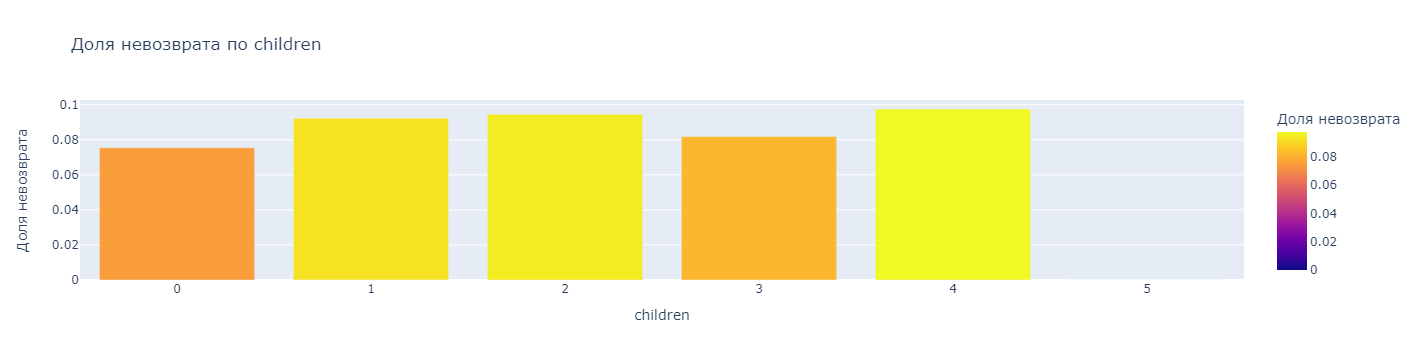

In [20]:
# Визуализируем долю невозвратных кредитов в зависимости от количества детей в семье заёмщика


def pivot(data, index):
    
    pivot = data.pivot_table(index = index, values = 'debt', aggfunc = ['count', 'sum', 'mean']).reset_index()
    pivot.columns = [index, 'Кол-во клиентов', 'Кол-во должников', 'Доля невозврата']
    display(pivot.sort_values('Доля невозврата', ascending = False))
    
    
    
    fig = px.bar(pivot, x = index, y = 'Доля невозврата', color = 'Доля невозврата', title = 'Доля невозврата по ' + index)
    fig.show()
    

pivot(data, 'children')

# Есть ли зависимость между количеством детей и возвратом кредита в срок?
Чтобы ответить на этот вопрос мы построим график, который будет показывать как изменяется доля кредитов вышедших на просрочку при увеличении количества детей. Но для начала эту долю надо посчитать.

In [21]:
#Учитывая, что последующие задания будут однотипные, сделаем функцию, которая считает процент просрочки 
#по оперделённой категории, поступающей в качестве переменной.
def cat_check(col):
    col_crosstab=pd.crosstab(data['debt'], data[col])
    col_crosstab.loc['Total']= col_crosstab.sum(axis = 0)
    col_crosstab.loc['share_of_problems']= round((col_crosstab.loc[1]/col_crosstab.loc['Total'])*100,1)
    col_crosstab.loc['share_of_good']= round((col_crosstab.loc[0]/col_crosstab.loc['Total'])*100,1)
    return(col_crosstab)
    
    
kids_crosstab=cat_check('children')
display(kids_crosstab)

children,0,1,2,3,4,5
debt,,,,,,
0,13028.0,4364.0,1858.0,303.0,37.0,9.0
1,1063.0,444.0,194.0,27.0,4.0,0.0
Total,14091.0,4808.0,2052.0,330.0,41.0,9.0
share_of_problems,7.5,9.2,9.5,8.2,9.8,0.0
share_of_good,92.5,90.8,90.5,91.8,90.2,100.0


In [22]:
#А теперь создадим функцию, чтобы визуализировать эту табилцу в форме интерактивных барчартов
def create_barchart(x_nums,y_nums,chart_title,axis_title):
    # создаем traces для визуализации
    trace0 = go.Bar(
    x=x_nums,
    y=y_nums
    )


    # создаем массив с данными и задаем title для графика и осей в layout
    layout = {'title': chart_title, 
              'xaxis': {'title': axis_title},'yaxis': {'title': 'Доля проблемных долгов,%'}
    }

    # создаем объект Figure и визуализируем его
    fig = go.Figure(data=trace0, layout=layout)
    iplot(fig, show_link=False)

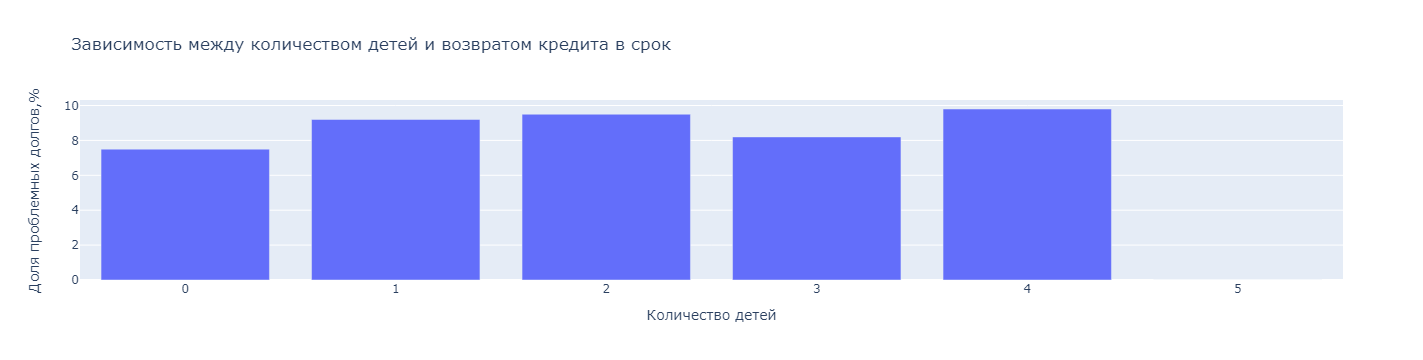

In [23]:
#визуализируем соотношение количества детей и неплатежей
create_barchart(kids_crosstab.columns,kids_crosstab.loc['share_of_problems'],
                'Зависимость между количеством детей и возвратом кредита в срок','Количество детей'
)

**Вывод напрашивается сам собой** - когда у тебя есть дети, платить по кредиту становится сложнее, причём с каждым новым ребёнком - доля просрочки растёт, исключение составляют семьи с тремя детьми, но они не ломают тренда. **Количество заёмщиков с 4  и 5 детьми настолько ничтожно, что их рассмотрение непоказательно. Даже семей с 3 детьми на порядок меньше, чем менее многодетных семей, так что и их более низкий уровень просрочек не факт что показателен.**

# Есть ли зависимость между семейным положением и возвратом кредита в срок?
Здесь мы будем действовать аналогично. Посчитаем долю неплательщиков по каждому типу семейного положения и посмотрим как это будет выглядеть на графике.

In [24]:
#посчитаем долю заёмщиков в каждой категории по семейному положению.
family_crosstab=cat_check('family_status')
display(family_crosstab)

family_status,Не женат / не замужем,в разводе,вдовец / вдова,гражданский брак,женат / замужем
debt,,,,,
0,2523.0,1105.0,888.0,3749.0,11334.0
1,273.0,84.0,63.0,385.0,927.0
Total,2796.0,1189.0,951.0,4134.0,12261.0
share_of_problems,9.8,7.1,6.6,9.3,7.6
share_of_good,90.2,92.9,93.4,90.7,92.4


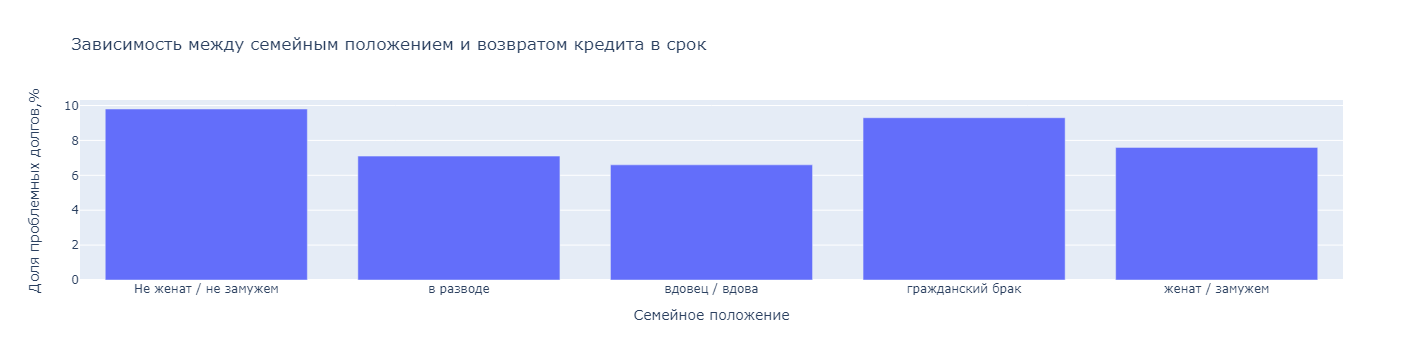

In [25]:
#визуализируем соотношение семейного положения и неплатежей
create_barchart(family_crosstab.columns,family_crosstab.loc['share_of_problems'],
                'Зависимость между семейным положением и возвратом кредита в срок','Семейное положение'
)


**Здесь вывод более однозначный.**
Есть небольшой блок условно одиноких людей, овдовевших или находящихся в разводе. Видимо эти битые жизнью люди привыкли осторожно обходиться с кредитами и их просрочки крайне редки. Те у кого официальный брак или хуже того - гражданский брак - имеют высокий рейтинг просрочников. Ну а неженатые/незамужние - абсолютные лидеры по просрочке. Вырисовывается такая картина, что только пройдя через горнило семейной жизни человек становится хорошим заёмщиком. **Но, есть также вероятность что тут больше влияет возраст, чем семейное положение, хорошая мысль для последующего более глубокого анализа.**

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
Тут нам пригодятся категории дохода, которые мы присвоили ранее. Давайте посмторим как по ним распределяется процент неплательщиков.

In [26]:
#посчитаем долю заёмщиков в каждой категории по доходам.
income_crosstab=cat_check('total_income_category')
display(income_crosstab)

total_income_category,A,B,C,D,E
debt,,,,,
0,23.0,4660.0,14568.0,328.0,20.0
1,2.0,354.0,1353.0,21.0,2.0
Total,25.0,5014.0,15921.0,349.0,22.0
share_of_problems,8.0,7.1,8.5,6.0,9.1
share_of_good,92.0,92.9,91.5,94.0,90.9


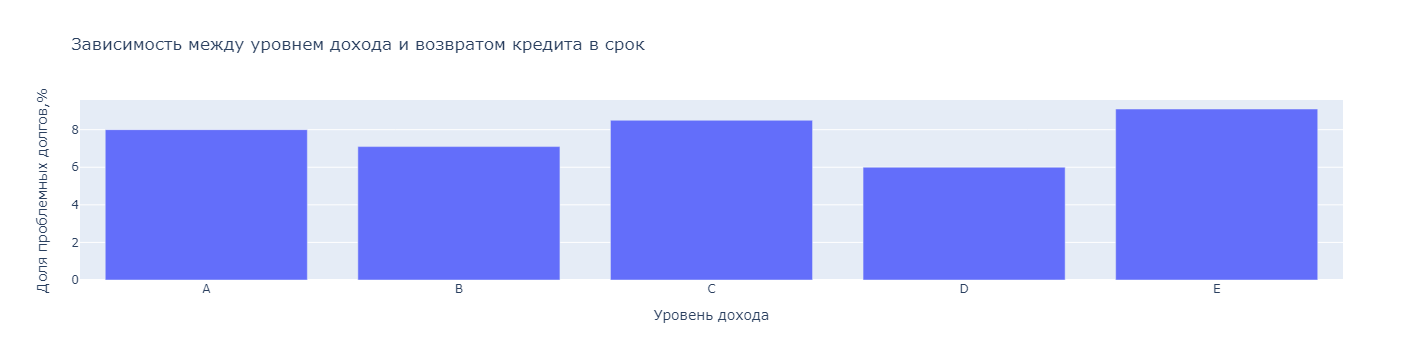

In [27]:
#визуализируем соотношение дохода и неплатежей
create_barchart(income_crosstab.columns,income_crosstab.loc['share_of_problems'],
                'Зависимость между уровнем дохода и возвратом кредита в срок','Уровень дохода'
)


**Вывод** К сожалению, предоставленная нам выборка, не позволяет сделать чётких выводов по категориям дохода А, D и E, так как количество таких заёмщиков слишком мало, и выбросы оказывают слишком сильное влияние.
По категориям В и С всё очевидно, со снижением уровня дохода, растёт количество невозвратов.

#### Как разные цели кредита влияют на его возврат в срок?

In [28]:
#посчитаем долю заёмщиков в каждой категории целей.
purpose_crosstab=cat_check('purpose_category')
display(purpose_crosstab)

purpose_category,операции с автомобилем,операции с недвижимостью,получение образования,проведение свадьбы
debt,,,,
0,3879.0,9971.0,3619.0,2130.0
1,400.0,780.0,369.0,183.0
Total,4279.0,10751.0,3988.0,2313.0
share_of_problems,9.3,7.3,9.3,7.9
share_of_good,90.7,92.7,90.7,92.1


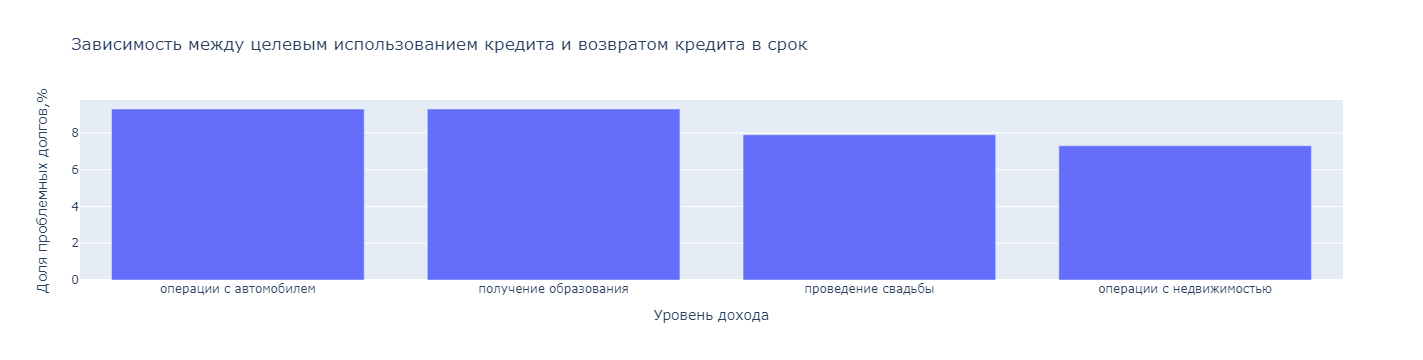

In [29]:
#для наглядности отсортируем по возрастанию уровня просрочки
purpose_crosstab=purpose_crosstab.T
purpose_crosstab=purpose_crosstab.sort_values('share_of_problems', ascending=False)
purpose_crosstab=purpose_crosstab.T
#визуализируем соотношение целевого использования и неплатежей
create_barchart(purpose_crosstab.columns,purpose_crosstab.loc['share_of_problems'],
                'Зависимость между целевым использованием кредита и возвратом кредита в срок','Уровень дохода'
)


**Вывод** невооруженным глазом видно два кластера - более рискованные цели и менее рискованные. Риск в операциях с автомобилем высок по причине того, что всё что связано с машинами это постоянно растущая статья затрат, и на кредит может не хватить. С образованием ещё грустнее - по статистике лишь 45% поступивших в ВУЗ заканчивают обучение, и уж тем более нет никакой корреляции с академической успешностью и уровнем дохода. Отсюда и проблемы с кредитами на образование. Свадьба и операции с недвижимостью - тесно коррелируют с российской системой ценностей - создать семью, построить дом, посадить дерево... Заёмщики взявшие ипотеку, будут до последнего расплачиваться, чтобы не оказаться зимой на улице, а на свадьбу обычно дарят деньги, которые частно направляются на погашение кредита, вдобавок при умелом ведении хозяйства в рамках семьи, расходы на 1 члена ниже, чем у двух одиночек. Это имеет внутреннюю логику. Для банка важно, что проценты по кредитам на свадьбы и недвижку можно делать пониже, а по автокредам и кредитам на образование, ставочку лучше приподнять. Ну и к оценке заёмщиков по этой целёвке подходить более взвешенно.

#### Возможные причины появления пропусков в исходных данных.

Традиционными причинами, приводящими к появлению пропусков, являются:
- невозможность получения или обработки данных;
- искажение или сокрытие информации;
- всевозможные поломки технического оборудования;
- природные явления;
- экономические причины (слишком дорого).

## Общий вывод <a name="chapter3"></a>

- 1) Качество данных, предоставленных для анализа можно оценить как "хорошее", пропуски и дубликаты не встречаются в угрожающих количествах, доля "мусорных" данных, способных вызвать критическую ошибку в обработке минимальна.
- 2) Ни один из предложенных факторов не даёт высокой корреляции с возвратом кредита, и не может быть использован единолично для принятия кредитного решения.
- 3) Проведённый анализ данных позволяет выделить группу факторов повышающих кредитный риск: наличие детей (уже сам факт повышает процент неплатежей минимум на 0,7%), семейное положение отличное от "разведен/вдовец", а если "не замужем/холост" - то значительный прирост кредитного риска. Низкий уровень дохода - тоже можно рассматривать как риск-фактор, ну и наконец, цель кредита - операции с автомобилями или с образованием - тоже повышают кредитный риск.
- 4) В качестве митигантов кредитного риска можно признать факторы: отсутствие детей, семейное положение: разведён/вдовец, более выхокий доход  и цель кредита - свадьба или операции с недвижимостью.
- 5) Одетльно следует сказать о доходе - предоставленных данных по категориям с самым высоким и самым низким доходом, недостаточно, чтобы оценить уровень просрочки с достаточно низкой статистической погрешностью. Необходимо расширить выборку для получения более тончых результатов.

**Справочно: Над данными были проведены следующие операции:**
- 1) Были выявлены пропуске в столбце со сведениями о доходах. Они были заменены медианными значениями по каждому типу занятости.
- 2) Были вявлены пропуски в столбце с данными о количестве дней занятости. Некоторые значения почему-то оказались отрицательными, они были заменены на такие же, но положительные. Ещё бросается в глаза, что безработные и пенсионеры имеют "страж" больше тысячи лет, что резко выделяется на общем фоне. Эти артефакты не исправлялись, так как не использовались в дальнейших вычислениях.
- 3) Встречалось анамальное количество детей (-1) и 20, данные строки были исключены из анализа.
- 4) В столбце с образованием имелись дубликаты, различавшиеся только регистром. Они были исключены из анализа.
- 5) Была произведена категоризация данных о дохода по предложенной шкале и целей использования кредита по укрупнённым группировкам по смыслу.

**Рекомендации закачику:**
- Расширить выборку.
- Выяснить почему некорректно отражается трудовой стаж у пенсионеров и безработных.
- Выяснить причины пропусков в столбце с величиной доходов.
- Составить таблицы со словарями целевого использования и уровня образования.